In [1]:
import os, glob, shutil, cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from scipy.optimize import curve_fit
from scipy.stats import linregress
from skimage.filters import threshold_otsu, threshold_yen, try_all_threshold, threshold_minimum
import skimage.measure as measure
from scipy.signal import find_peaks

In [2]:
#find videos
print(f'Current directory: {os.getcwd()}')

path_to_videos = glob.glob(os.path.join('Videos','*.avi'))
print(path_to_videos, '-'*10, sep = '\n')
#create required directories
def makefolders(path):
    folder = os.path.split(path) #create folders for extracting all images
    folder = os.path.splitext(folder[-1])
    folder_create = os.path.join('Videos',folder[0])
    if os.path.exists(folder_create) == False:
        os.mkdir(folder_create)
    else:
        pass
    return folder_create

#navigate into folder for the image and save images
def saveimages(path, dir_name):
    cam = cv2.VideoCapture(path)
    count, success = 0, True
    video_index = []
    while success:
        success, image = cam.read()
        if not cam.isOpened():
            print(f"Error: Could not open video file {path}")
        os.chdir(dir_name)
        if success:
            folder = os.path.split(dir_name)
            frame = f'{folder[-1]}_frame_{count:02}.jpg'
            video_index.append(frame)
            if os.path.exists(frame) == False:
                cv2.imwrite(frame, image)
                count+=1
            else:
                print(f'{frame} already exists, skipping save')
                count+=1
        else:
            print('End of file')
        os.chdir(os.path.join('..','..'))
    cam.release()
    print(f'Current directory: {os.getcwd()} \n Completed {path}\n--------------------')
    return video_index

def hill_eqn(c,K,n): #c concentration, K constant, n Hill coefficient
    lnc = np.log(c)
    x = K*np.exp(-n*lnc)
    E = 1/(1+x)
    return E #E is effect

Current directory: /Users/justinyew/Documents/GitHub/AppChallenge2273-2024/Project
['Videos/XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h.avi', 'Videos/XtremeStr-li1.5ug_biotin_no drug_live_5min45min.avi', 'Videos/0.5ugDNA_drug10uM_5min45min_1.avi', 'Videos/LipoKDEL1ug_biotin_no drug_live_5min1h.avi', 'Videos/0.75ugDNA_drug10uM_5min45min_1.avi', 'Videos/1ugDNA_drug10uM_5min45min_1.avi', 'Videos/LipoKDEL1ug_biotin_drug25uM_live_5min1h.avi']
----------


In [5]:
video_indexes = []
folder_indexes = []
vf_dict = {}
for path in path_to_videos:
    dir_name = makefolders(path)
    folder_indexes.append(dir_name)
    img_names = saveimages(path, dir_name)
    video_indexes.append(img_names)
    vf_dict[os.path.split(dir_name)[-1]] = img_names

print(vf_dict.keys())
for key, item in vf_dict.items():
    print(key, item)

XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_00.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_01.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_02.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_03.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_04.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_05.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_06.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_07.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_08.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_09.jpg already exists, skipping save
XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h_frame_10.jpg already exists, skipping save
XtremeStr-li1.5ug_bio

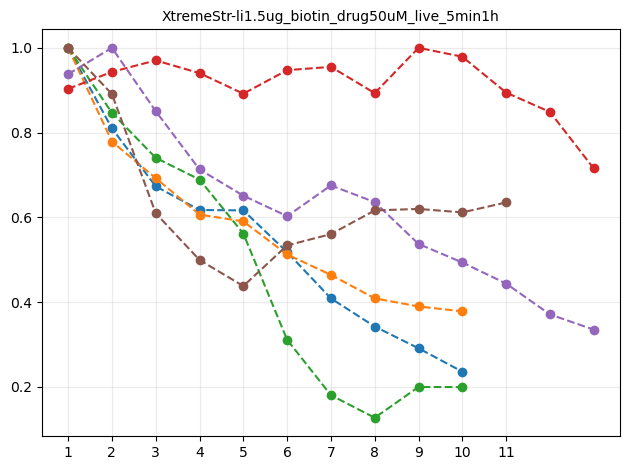

In [53]:
# This works, for our new approach.
cwd = os.getcwd() #getting current working directory

temp = glob.glob(os.path.join(cwd, 'Videos', '*')) #in my current working directory, access videos folder and list me all the files inside
video_folders = [file for file in temp if not file.endswith(".avi")] 
#using list comprehension. access the files inside temp, isolate the files with '.avi', and exclude it. store as video_folders

folders_to_process = ('LipoKDEL1ug_biotin_no drug_live_5min1h',  'LipoKDEL1ug_biotin_drug25uM_live_5min1h', 
                      'XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h',
                      '0.5ugDNA_drug10uM_5min45min_1', '0.75ugDNA_drug10uM_5min45min_1', '1ugDNA_drug10uM_5min45min_1')

testing = {'0.5ugDNA_drug10uM_5min45min_1': [(300,500, 400,600)],
           '0.75ugDNA_drug10uM_5min45min_1': [(300,475, 375,550)],
           '1ugDNA_drug10uM_5min45min_1': [(400,550, 180,300)],
           'LipoKDEL1ug_biotin_drug25uM_live_5min1h': [(625,740, 600,720)],
           'LipoKDEL1ug_biotin_no drug_live_5min1h': [(550,690, 450,600)],
           'XtremeStr-li1.5ug_biotin_drug50uM_live_5min1h': [(285,400, 70,150)]
}
         #   'Videos\\XtremeStr-li1.5ug_biotin_no drug_live_5min45min': []
         # }

all_video_values = [] #empty list to add the arrays generated for all 7 videos into 1 list, for downstream works.

#creating a function called extract_fluorescenceData, to loop through the 7 different folders.
def extract_fluorescenceData(folder_path, img_order, resolutions): 
    total_fluorescence = [] #empty list to add the max fluoresence later and plot
    subdir_path = os.path.join(cwd,'Videos', folder_path) #create path to directory in the iteration

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in img_order:
            img_path = os.path.join(subdir_path, img)
            if os.path.exists(img_path): #filter for only .jpg files inside subdir_path
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                y1, y2, x1, x2 = resolutions
                cropped_img = img_gray[y1:y2, x1:x2]
                total_fluorescence.append(cropped_img.sum()) #sum up signal inside individual frames and append into total_fluorascence
    else:
        print(f'Subdirectory {video_folders} not found')
    return total_fluorescence #return here so can use in "histogrammer" function. this variable will be 'video1' in histogrammer function

def histogrammer(video1, n): #video1 is an array of the max fluorescence values, i simply stands for index
    video1_normalise = video1/max(video1) #normalising to highest sum fluorescent signal in the frames.
    name = os.path.split(n) #split it by \\ into index, where [0] = your directory and [i] in this case is folder names
    x = range(1, len(video1)+1) #plotting frame 1 to n+1

    #plotting segment
    plt.plot(x, video1_normalise, linestyle = 'dashed', marker = 'o') #marker is the data point, marked as circle.

    #Labels & aesthetics
    plt.xticks(x) #this makes it show every tick in X axis
    # plt.xlabel('Frame number', fontsize = 10)
    # plt.ylabel('Total fluorescence signal', fontsize = 10)
    plt.grid(alpha = .25)
    plt.title(name[1], fontsize = 10) #name[1] as my first index will be my path, second index is filename
    plt.tight_layout()
    # plt.savefig(f'Graph for {name[1]}.jpg', dpi = 300) #added saving of plots! #visualisation purposes only, for the output

for key in testing.keys():
    for i in range(len(testing[key])):
        video1 = extract_fluorescenceData(key, vf_dict[key], testing[key][i])
        histogrammer(video1, key)

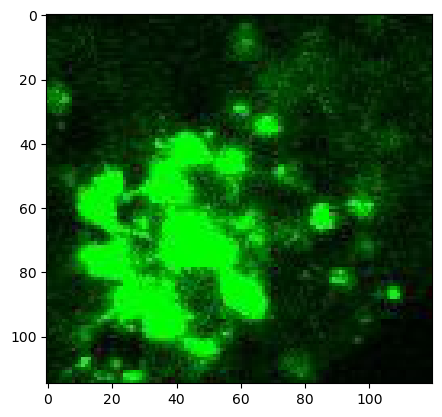

In [54]:
#goal: identify green regions and calculate area to intensity ratio for lipoKDEL1ug_biotin_drug25uM
video = {'LipoKDEL1ug_biotin_drug25uM_live_5min1h': (625,740, 600,720)}

img_path = 'LipoKDEL1ug_biotin_drug25uM_live_5min1h_frame_03.jpg'
img = plt.imread(os.path.join('Videos',list(video.keys())[0], img_path))
img = img[625:740,600:720]

plt.imshow(img)

img_grey = rgb2gray(img)
plt.show()

# plt.hist(img_grey, bins = 100)
# plt.show()

# fig, ax = try_all_threshold(img_grey, figsize=(10, 8), verbose=False)
# plt.show()

# plt.imshow(img_grey, cmap='jet')
# plt.show()

val, freq = np.unique(img_grey, return_counts = True)
# print(val[np.argmax(freq)])
peaks = find_peaks(freq) # will need to smooth this out tomorrow, learn how to use pandas



# for i in peaks:
#     try:
#         if i.dtype == 'int64':
#             print(val[i])
#     except AttributeError:
#         pass

12079.0
---------- Region 0 ----------
Centre	: (54.99279741700472, 62.17700140740128)
Area	: 12079.0


---------- Region 1 ----------
Centre	: (84.0, 34.5)
Area	: 2.0




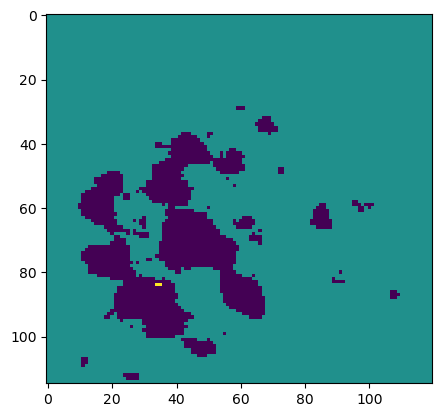

In [55]:
threshold = threshold_minimum(img_grey)
img_binarised = img_grey < threshold

img_labelled = measure.label(img_binarised.astype('uint8'))
plt.imshow(img_labelled)
 # measure.label() requires an image of type int
img_labelled = measure.label(img_binarised.astype('uint8'))
region_info = measure.regionprops(img_labelled)
print(region_info[0].area)

no_of_regions = len(region_info)

for count, region in enumerate(region_info):
    print('-'*10, f'Region {count}', '-'*10)
    print(f'Centre\t: {region.centroid}')
    print(f'Area\t: {region.area}')             # What is the area
    print('\n')

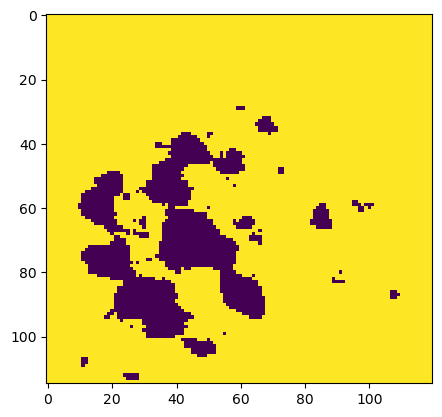

In [56]:
img_masked = img_labelled == 1
plt.imshow(img_masked)
plt.show()

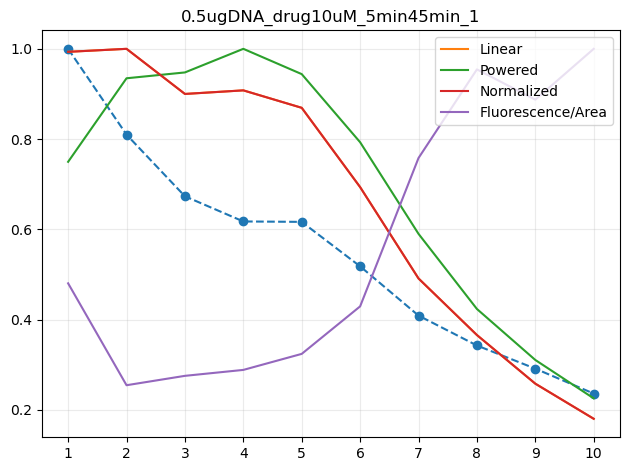

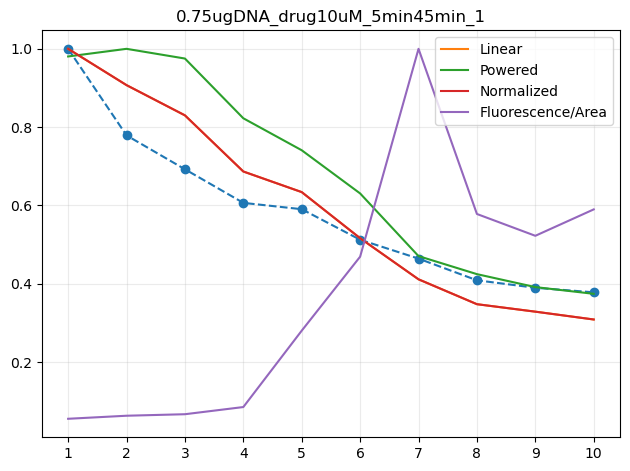

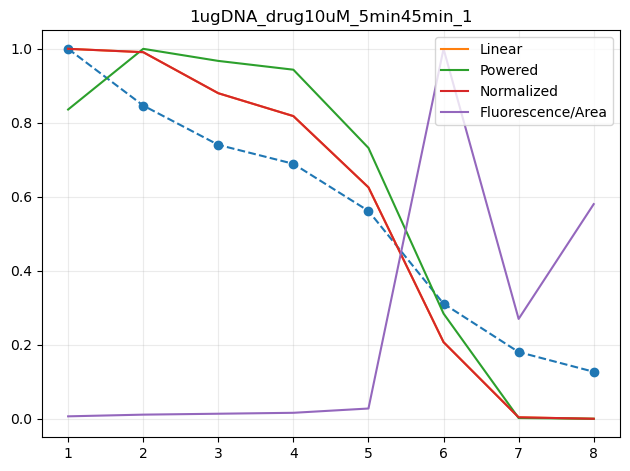

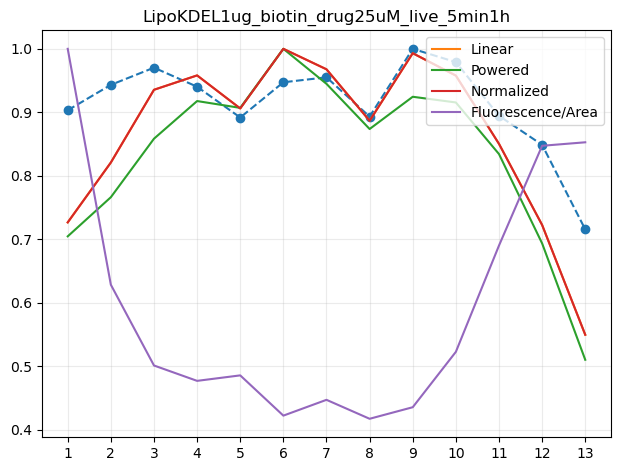

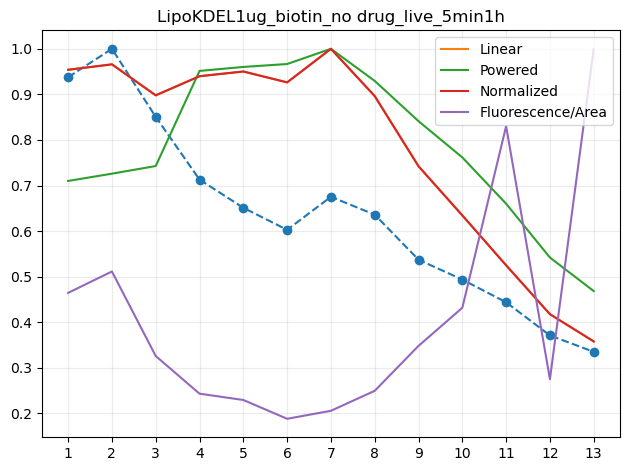

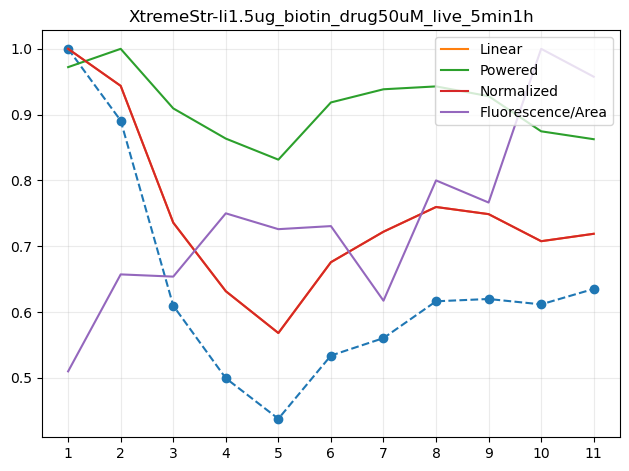

In [116]:
def ratio_Data(folder_path, img_order, resolutions): 
    total_fluorescence, areas = [], []
    subdir_path = os.path.join(cwd,'Videos', folder_path) #create path to directory in the iteration

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in img_order:
            img_path = os.path.join(subdir_path, img)
            if os.path.exists(img_path):
            # if img.lower().endswith('.jpg'): #filter for only .jpg files inside subdir_path
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                y1, y2, x1, x2 = resolutions
                cropped_img = img_gray[y1:y2, x1:x2]

                try:
                    threshold = threshold_minimum(cropped_img)
                    binarised_img = cropped_img < threshold
                    img_labelled = measure.label(binarised_img.astype('uint8'))
                    region_info = measure.regionprops(img_labelled)
                # plt.imshow(binarised_img, cmap = 'gray')
                # plt.show()
                
                    total_fluorescence.append(cropped_img.sum()) #sum up signal inside individual frames and append into total_fluorascence
                    areas.append((y2-y1)*(x2-x1) - region_info[0].area)
                except RuntimeError:
                    print(f'Error with {img} image')
                    pass
    else:
        print(f'Subdirectory {video_folders} not found')
    ratio = np.array(total_fluorescence)/np.array(areas)
    return ratio

def overlay_threshold(folder_path, img_order, resolutions, return_base = True): 
    total_fluorescence, areas = [], []
    subdir_path = os.path.join(cwd,'Videos', folder_path) #create path to directory in the iteration
    y1, y2, x1, x2 = resolutions
    # if os.path.exists(os.path.join(subdir_path, img_order[0])):
    #     first = plt.imread(os.path.join(subdir_path, img_order[0]))
    #     first = rgb2gray(first)
    #     first = first[y1:y2,x1:x2] #yes we could find this by math but i wanted to get it to work first
    # print(y2-y1,x2-x1, first.shape)
    overlay = np.zeros((y2-y1,x2-x1))

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in img_order:
            img_path = os.path.join(subdir_path, img)
            if os.path.exists(img_path):
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                cropped_img = img_gray[y1:y2, x1:x2]
                cropped_img = noise_remove(cropped_img)
                overlay+=cropped_img
                # val, freq = np.unique(cropped_img, return_counts = True)
                # # threshold = val[np.argmax(freq)]
                # threshold = 0.4
                # cropped_img[cropped_img < threshold] = 0
                
                # total_fluorescence.append(cropped_img.sum()) #sum up signal inside individual frames and append into total_fluorascence
    else:
        print(f'Subdirectory {video_folders} not found')
    if return_base == True:
        return extract_Data(folder_path, img_order, resolutions, overlay), overlay
    else:
        return overlay

def extract_Data(folder_path, img_order, resolutions, overlay): 
    total_fluorescence = [] #empty list to add the max fluoresence later and plot
    subdir_path = os.path.join(cwd,'Videos', folder_path) #create path to directory in the iteration

    if os.path.isdir(subdir_path): #checking if subdirectory path exist
        for img in img_order:
            img_path = os.path.join(subdir_path, img)
            if os.path.exists(img_path): #filter for only .jpg files inside subdir_path
                a=plt.imread(img_path) #need save plt.imread to a variable, if not cannot plot downstream
                img_gray = rgb2gray(a) #converting the img into grayscale
                y1, y2, x1, x2 = resolutions
                cropped_img = img_gray[y1:y2, x1:x2]
                cropped_img = noise_remove(cropped_img)
                cropped_img *= overlay
                total_fluorescence.append(cropped_img.sum()) #sum up signal inside individual frames and append into total_fluorascence
    else:
        print(f'Subdirectory {video_folders} not found')
    return total_fluorescence

def power_overlay(overlay):
    overlay = overlay**4
    return overlay

def norm_overlay(overlay):
    overlay = overlay/np.max(overlay)
    return overlay

def get_label(filepath):
    # x=list(testing.keys())[4]
    label=[fragments for fragments in filepath.split('_') if 'drug' in fragments]
    return label[0].upper()

def noise_remove(img):
    mask = img < 0.15
    img[mask] = 0
    return img

# for i, key in enumerate(testing):
#     labels = get_label(key)
#     total_f = modified(key, vf_dict[key], testing[key][0])
#     total_f = total_f/max(total_f)
#     frame_numbers = np.arange(1,len(total_f)+1)
#     plt.plot(frame_numbers, total_f, '.', linestyle = 'dashed', label = labels)
# plt.legend(loc = 'upper right')
# plt.show()

for key in testing:
    video1 = extract_fluorescenceData(key, vf_dict[key], testing[key][i])
    histogrammer(video1, key)
    
    img_overlay, overlay = overlay_threshold(key, vf_dict[key], testing[key][0])
    img_overlay = img_overlay/max(img_overlay)
    overlay1 = power_overlay(overlay)
    img_squared = extract_Data(key, vf_dict[key], testing[key][0], overlay1)
    img_squared = img_squared/max(img_squared)
    overlay2 = norm_overlay(overlay)
    img_norm = extract_Data(key, vf_dict[key], testing[key][0], overlay2)
    img_norm = img_norm/max(img_norm)
    ratio_f = ratio_Data(key, vf_dict[key], testing[key][0])
    ratio_f = ratio_f/max(ratio_f)
    
    frames = np.arange(1,len(img_overlay)+1)
    plt.plot(frames, img_overlay, label = "Linear")
    plt.plot(frames, img_squared, label = "Powered")
    plt.plot(frames, img_norm, label = 'Normalized')
    plt.plot(frames, ratio_f, label = 'Fluorescence/Area')
    plt.title(key)
    plt.legend(loc = 'upper right')
    plt.show()

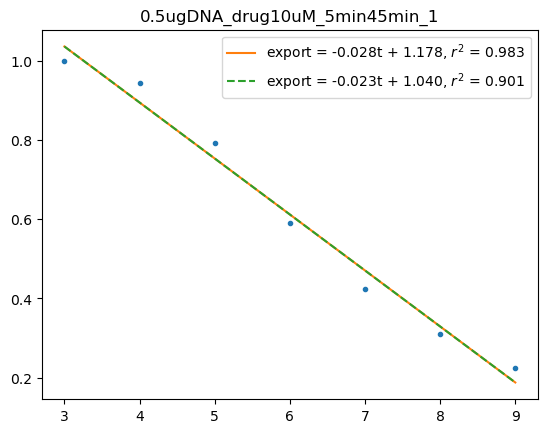

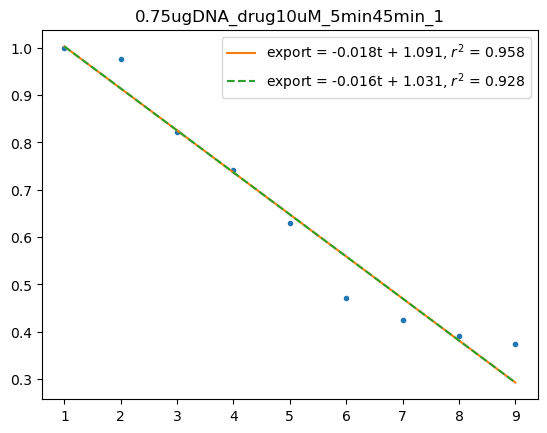

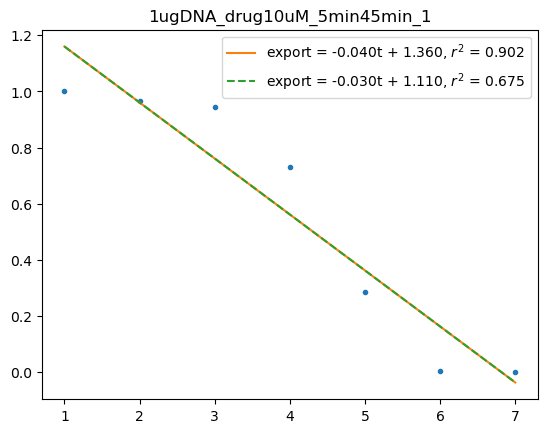

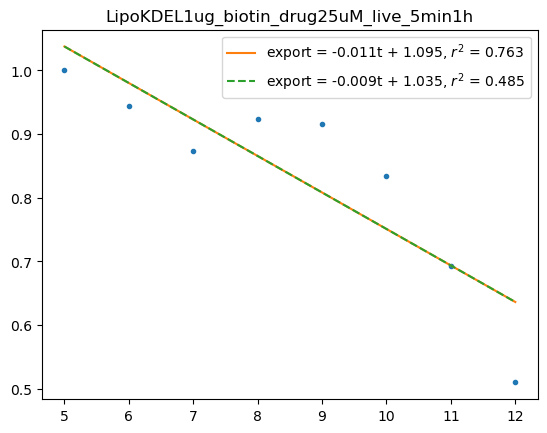

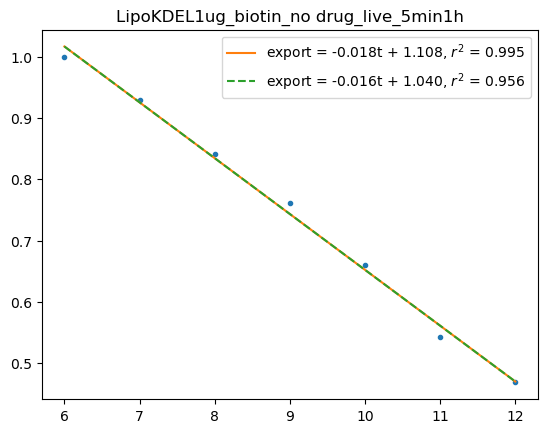

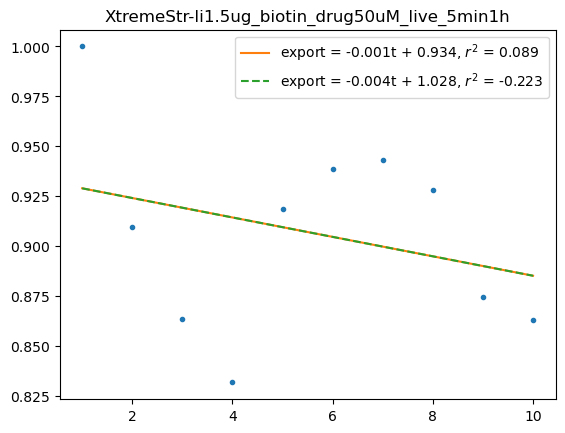

In [117]:
#chosen function: power
def linear_relation(t,m,c):
    export = m*t + c
    return export

def dcdt(t,m,c,f_actual): #vary b0
    f_predicted = linear_relation(t,m,c)
    a = np.sum(f_actual - f_predicted)
    b = -2/len(f_actual)
    const = a * b
    return const

def dmdt(t,m,c,f_actual): #vary b1
    f_predicted = linear_relation(t,m,c)
    a = np.sum((f_actual - f_predicted) * t)
    b = -2/len(f_actual)
    gradient = a * b
    return gradient

def get_lineEqn(m, c, t, f_i, max_iter=10000, lr = 1e-4, tol = 1e-5):
    for _ in range(max_iter):
        diff1 = dcdt(t,m,c,f_i)*lr
        diff2 = dmdt(t,m,c,f_i)*lr
        if abs(diff1) < tol and abs(diff2) < tol:
            break
        else:
            c-=diff1
            m-=diff2
    return m,c

def rss(y_predicted, y_actual):
    return np.sum((y_actual-y_predicted)**2)

def tss(y_predicted, y_actual):
    y_ave = np.average(y_actual)
    return np.sum((y_predicted-y_ave)**2)

def r2calc(y1, ya):
    r2 = 1 - (rss(y1,ya)/tss(y1,ya))
    return r2

for key in testing:
    heat_map = overlay_threshold(key, vf_dict[key], testing[key][0], return_base = False)
    weighted_fluorescence = extract_Data(key, vf_dict[key], testing[key][0], power_overlay(heat_map))
    weighted_fluorescence = weighted_fluorescence/np.max(weighted_fluorescence)
    max_index = np.where(weighted_fluorescence == np.max(weighted_fluorescence))
    export = weighted_fluorescence[max_index[0][0]:]
    frames = np.arange(max_index[0][0],len(weighted_fluorescence))
    t = (np.arange(1,len(export)+1))*5
    plt.plot(frames, export, '.')
    plt.title(key)

    function = linregress(t,export, alternative = 'less')
    line = linear_relation(t, function.slope, function.intercept)
    plt.plot(frames, line, label = r'export = {:.3f}t + {:.3f}, $r^2$ = {:.3f}'.format(function.slope,function.intercept,function.rvalue**2))

    m, c = get_lineEqn(m=-1,c=1, t=t, f_i = export)
    my_line = linear_relation(t,m,c)
    r2 = r2calc(my_line, export)
    plt.plot(frames, line, label = r'export = {:.3f}t + {:.3f}, $r^2$ = {:.3f}'.format(m, c, r2), linestyle = 'dashed')
    plt.legend(loc = 'upper right')
    plt.show()